In [1]:
!pip install google

In [2]:
!pip install transformers 

     |████████████████████████████████| 2.1MB 7.5MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 
     |████████████████████████████████| 3.3MB 50.3MB/s 


In [3]:
!nvidia-smi

Fri May  7 07:12:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch 

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
df = pd.read_csv('URL_dataset.csv')
df = df[0:230000]
df

,Unnamed: 0,URL,Result
0,0,http://1337x.to/torrent/1048648/American-Snipe...,0
1,1,http://1337x.to/torrent/1110018/Blackhat-2015-...,0
2,2,http://1337x.to/torrent/1122940/Blackhat-2015-...,0
3,3,http://1337x.to/torrent/1124395/Fast-and-Furio...,0
4,4,http://1337x.to/torrent/1145504/Avengers-Age-o...,0
...,...,...,...
229995,231141,http://www.plasmacamcnc.com/index.php?option=c...,1
229996,231142,http://www.plasmacamcnc.com/index.php?option=c...,1
229997,231143,http://www.plasmacamcnc.com/index.php?option=c...,1
229998,231144,http://www.plasmacamcnc.com/index.php?option=c...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


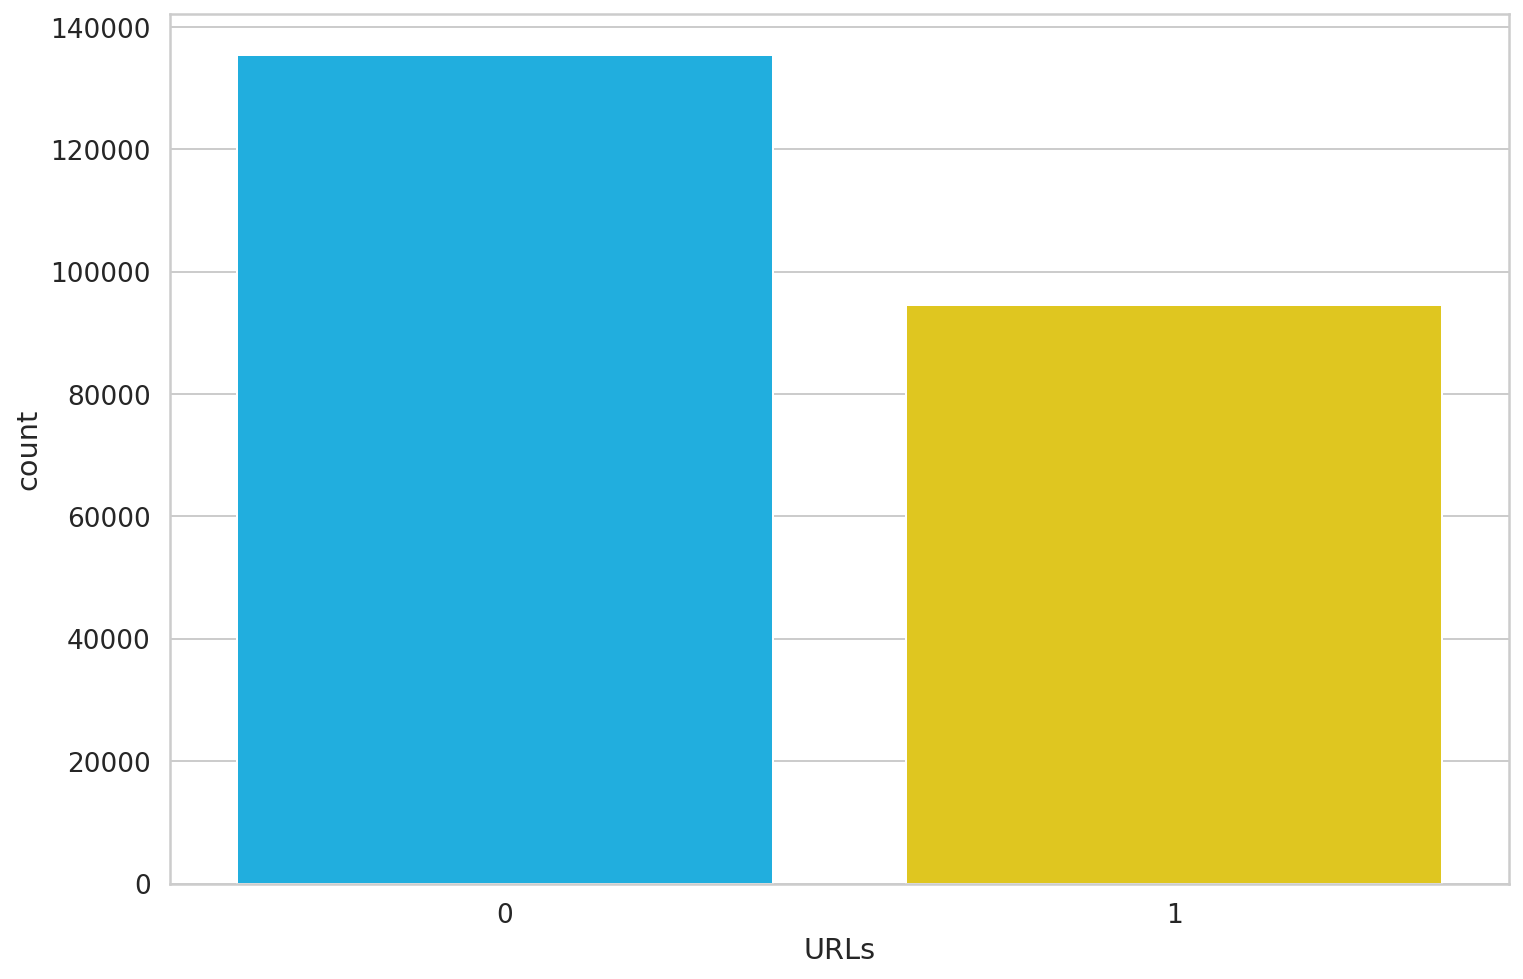

In [7]:
sns.countplot(df.Result)
plt.xlabel('URLs');

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'https://eksisozluk.com/?q=%c3%b6%c4%9frenildi%c4%9finde+ufku+iki+kat%c4%b1na+%c3%a7%c4%b1karan+%c5%9feyler%2f%2351261054'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: https://eksisozluk.com/?q=%c3%b6%c4%9frenildi%c4%9finde+ufku+iki+kat%c4%b1na+%c3%a7%c4%b1karan+%c5%9feyler%2f%2351261054
   Tokens: ['https', ':', '/', '/', 'e', '##ks', '##is', '##oz', '##luk', '.', 'com', '/', '?', 'q', '=', '%', 'c', '##3', '%', 'b', '##6', '%', 'c', '##4', '%', '9', '##f', '##ren', '##il', '##di', '%', 'c', '##4', '%', '9', '##fin', '##de', '+', 'u', '##f', '##ku', '+', 'i', '##ki', '+', 'ka', '##t', '%', 'c', '##4', '%', 'b', '##1', '##na', '+', '%', 'c', '##3', '%', 'a', '##7', '%', 'c', '##4', '%', 'b', '##1', '##kara', '##n', '+', '%', 'c', '##5', '%', '9', '##fe', '##yler', '%', '2', '##f', '%', '235', '##12', '##6', '##10', '##5', '##4']
Token IDs: [18630, 131, 120, 120, 174, 4616, 1548, 17395, 17086, 119, 3254, 120, 136, 186, 134, 110, 172, 1495, 110, 171, 1545, 110, 172, 1527, 110, 130, 2087, 5123, 2723, 3309, 110, 172, 1527, 110, 130, 16598, 2007, 116, 190, 2087, 4786, 116, 178, 2293, 116, 24181, 1204, 110, 172, 1527, 110, 171, 1475, 1605, 116, 

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101, 18630,   131,   120,   120,   174,  4616,  1548, 17395, 17086,
          119,  3254,   120,   136,   186,   134,   110,   172,  1495,   110,
          171,  1545,   110,   172,  1527,   110,   130,  2087,  5123,  2723,
         3309,   102])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'https',
 ':',
 '/',
 '/',
 'e',
 '##ks',
 '##is',
 '##oz',
 '##luk',
 '.',
 'com',
 '/',
 '?',
 'q',
 '=',
 '%',
 'c',
 '##3',
 '%',
 'b',
 '##6',
 '%',
 'c',
 '##4',
 '%',
 '9',
 '##f',
 '##ren',
 '##il',
 '##di',
 '[SEP]']

In [ ]:
token_lens = []

for txt in df.URL:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


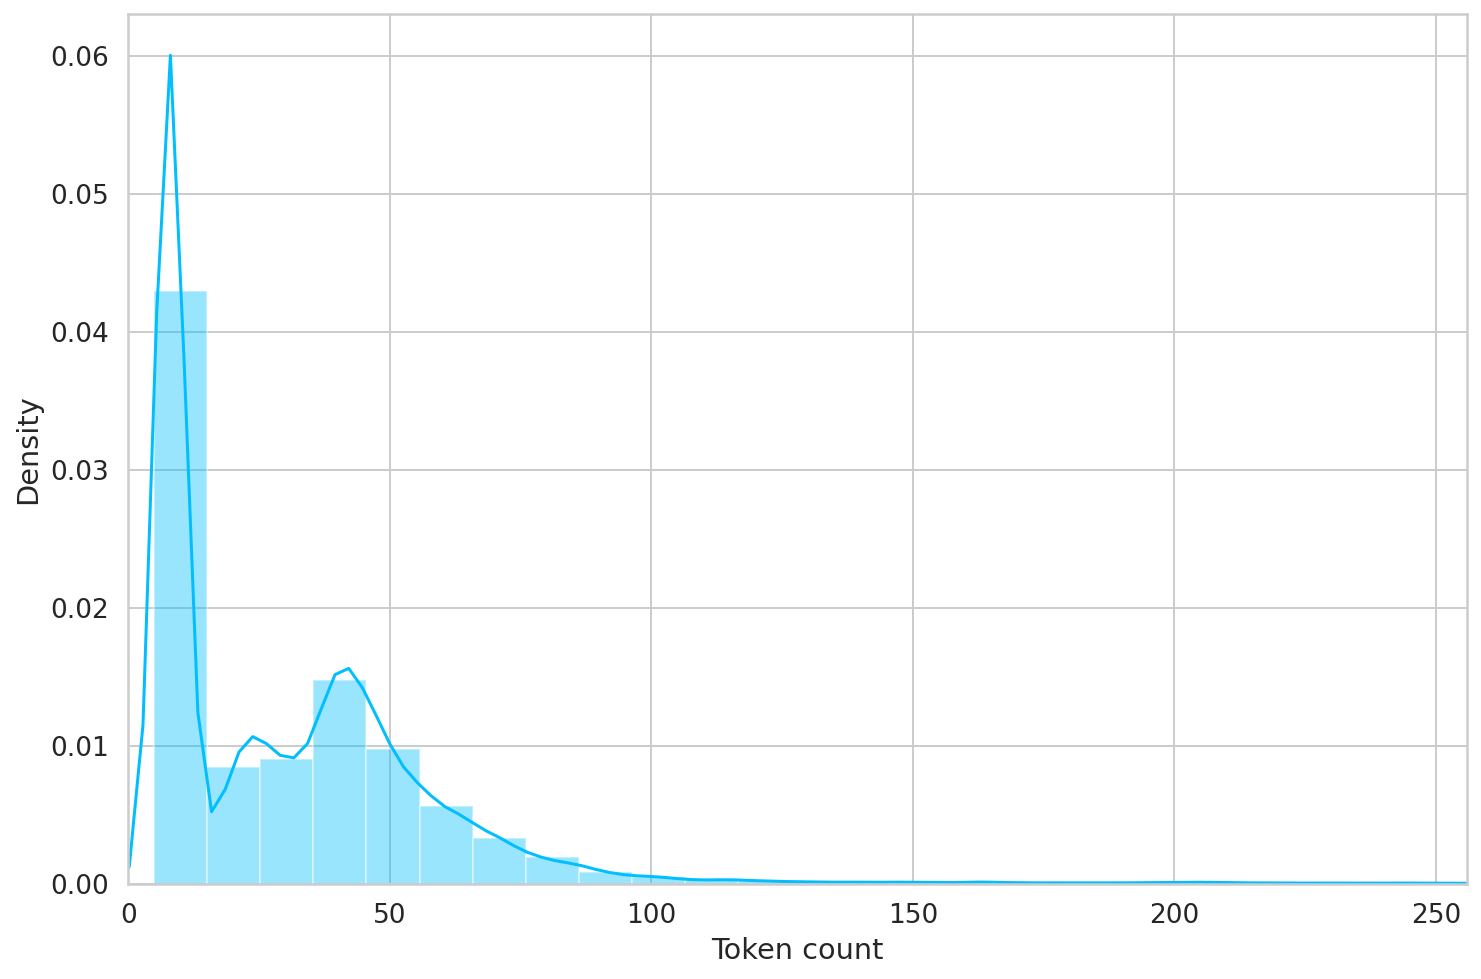

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 150

In [ ]:
class URLClassifier(Dataset):

  def __init__(self, URL, Result, tokenizer, max_len):
    self.URL = URL
    self.Result = Result
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.URL)
  
  def __getitem__(self, item):
    review = str(self.URL[item])
    Result = self.Result[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'URL': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'Result': torch.tensor(Result, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((207000, 3), (11500, 3), (11500, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = URLClassifier(
    URL=df.URL.to_numpy(),
    Result=df.Result.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['URL', 'input_ids', 'attention_mask', 'Result'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['Result'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)[0]
pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)[1]

In [ ]:
last_hidden_state

tensor([[[ 0.4133,  0.1249, -0.0331,  ..., -0.0455,  0.2967,  0.1258],
         [ 0.6600, -0.4629,  0.3825,  ..., -0.4616,  0.5921,  0.6722],
         [-0.2573, -0.5128, -0.3704,  ...,  0.1391, -0.1300,  0.5752],
         ...,
         [ 0.3069, -0.8786,  0.2736,  ...,  0.2698,  0.0976,  0.6001],
         [ 0.0345,  0.0268,  0.0452,  ...,  0.0811,  0.5157,  0.2206],
         [ 0.4183,  0.3423, -0.4703,  ...,  0.2431,  1.0085, -0.0466]]],
       grad_fn=<NativeLayerNormBackward>)

In [ ]:
pooled_output

tensor([[-0.6571,  0.3709,  0.9997, -0.9891,  0.9273,  0.9666,  0.9459, -0.9969,
         -0.9450, -0.5524,  0.9758,  0.9977, -0.9995, -0.9997,  0.9036, -0.9465,
          0.9842, -0.4679, -0.9999, -0.6885, -0.6819, -0.9998,  0.1371,  0.9846,
          0.9465, -0.0102,  0.9787,  0.9999,  0.6981, -0.2571,  0.2062, -0.9864,
          0.9304, -0.9984,  0.1664,  0.4756,  0.8525, -0.1936,  0.8605, -0.9664,
         -0.5268, -0.6344,  0.7096, -0.4768,  0.9409,  0.1541, -0.0550, -0.0923,
          0.0587,  0.9996, -0.9003,  0.9085, -0.9984,  0.9603,  0.9901,  0.3440,
          0.9923,  0.1543, -0.9997,  0.0816,  0.9698,  0.3044,  0.8178,  0.0284,
          0.3372, -0.5663, -0.9257,  0.0648, -0.5112,  0.3576,  0.0483,  0.2618,
          0.9219, -0.8531, -0.0664, -0.9088, -0.1557, -0.9998,  0.9505,  0.9999,
          0.8009, -0.9996,  0.9849, -0.1881, -0.8103,  0.8457, -0.9999, -0.9991,
          0.0048, -0.3660,  0.9403, -0.9819,  0.6713, -0.9298,  0.9999, -0.9629,
         -0.1766,  0.2319,  

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class FinalClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FinalClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['Safe', 'Malicious'] #class_names = ['Safe', 'Defacement', 'Malware', 'Phishing', 'Spam']

In [ ]:
model = FinalClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6867, 0.3133],
        [0.7833, 0.2167],
        [0.6554, 0.3446],
        [0.8011, 0.1989],
        [0.7703, 0.2297],
        [0.6800, 0.3200],
        [0.7697, 0.2303],
        [0.5571, 0.4429],
        [0.6857, 0.3143],
        [0.5113, 0.4887],
        [0.7101, 0.2899],
        [0.6589, 0.3411],
        [0.8684, 0.1316],
        [0.7382, 0.2618],
        [0.6988, 0.3012],
        [0.6446, 0.3554]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    Result = d["Result"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, Result)

    correct_predictions += torch.sum(preds == Result)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      Result = d["Result"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, Result)

      correct_predictions += torch.sum(preds == Result)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_3.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.00851553768855441 accuracy 0.9982898550724638


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.0010031999634325182 accuracy 0.9997391304347827

Epoch 2/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.00039024807779688053 accuracy 0.9999371980676328


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.0003784145301311468 accuracy 0.9999130434782609

CPU times: user 1h 44min 16s, sys: 1h 28min 31s, total: 3h 12min 47s
Wall time: 3h 13min 27s


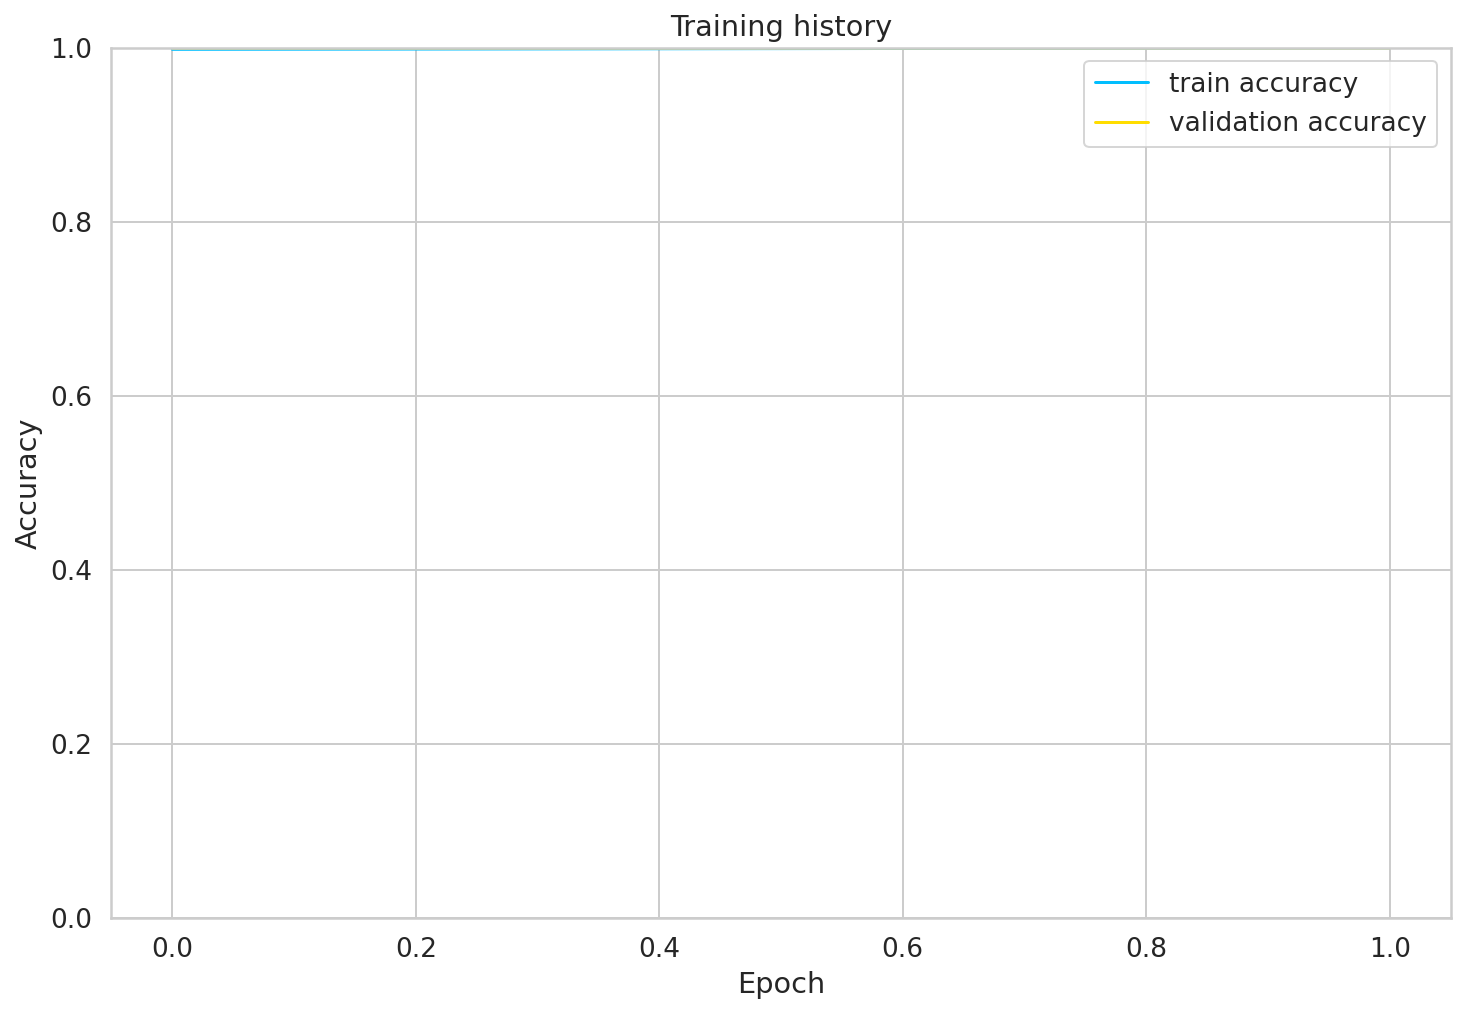

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
0.59
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
# The lines are all the way at the top at 1.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/best_model_state_3.bin /content/drive/MyDrive

## Stored model is brought out and tested at this point

In [ ]:
dp_model = FinalClassifier(len(class_names))
dp_model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state_3.bin'))
dp_model = dp_model.to(device)

In [ ]:
dp_model

FinalClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.9999130434782609

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  URL = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["URL"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["Result"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      URL.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return URL, predictions, prediction_probs, real_values

In [ ]:
y_url_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00      6765
   Malicious       1.00      1.00      1.00      4735

    accuracy                           1.00     11500
   macro avg       1.00      1.00      1.00     11500
weighted avg       1.00      1.00      1.00     11500



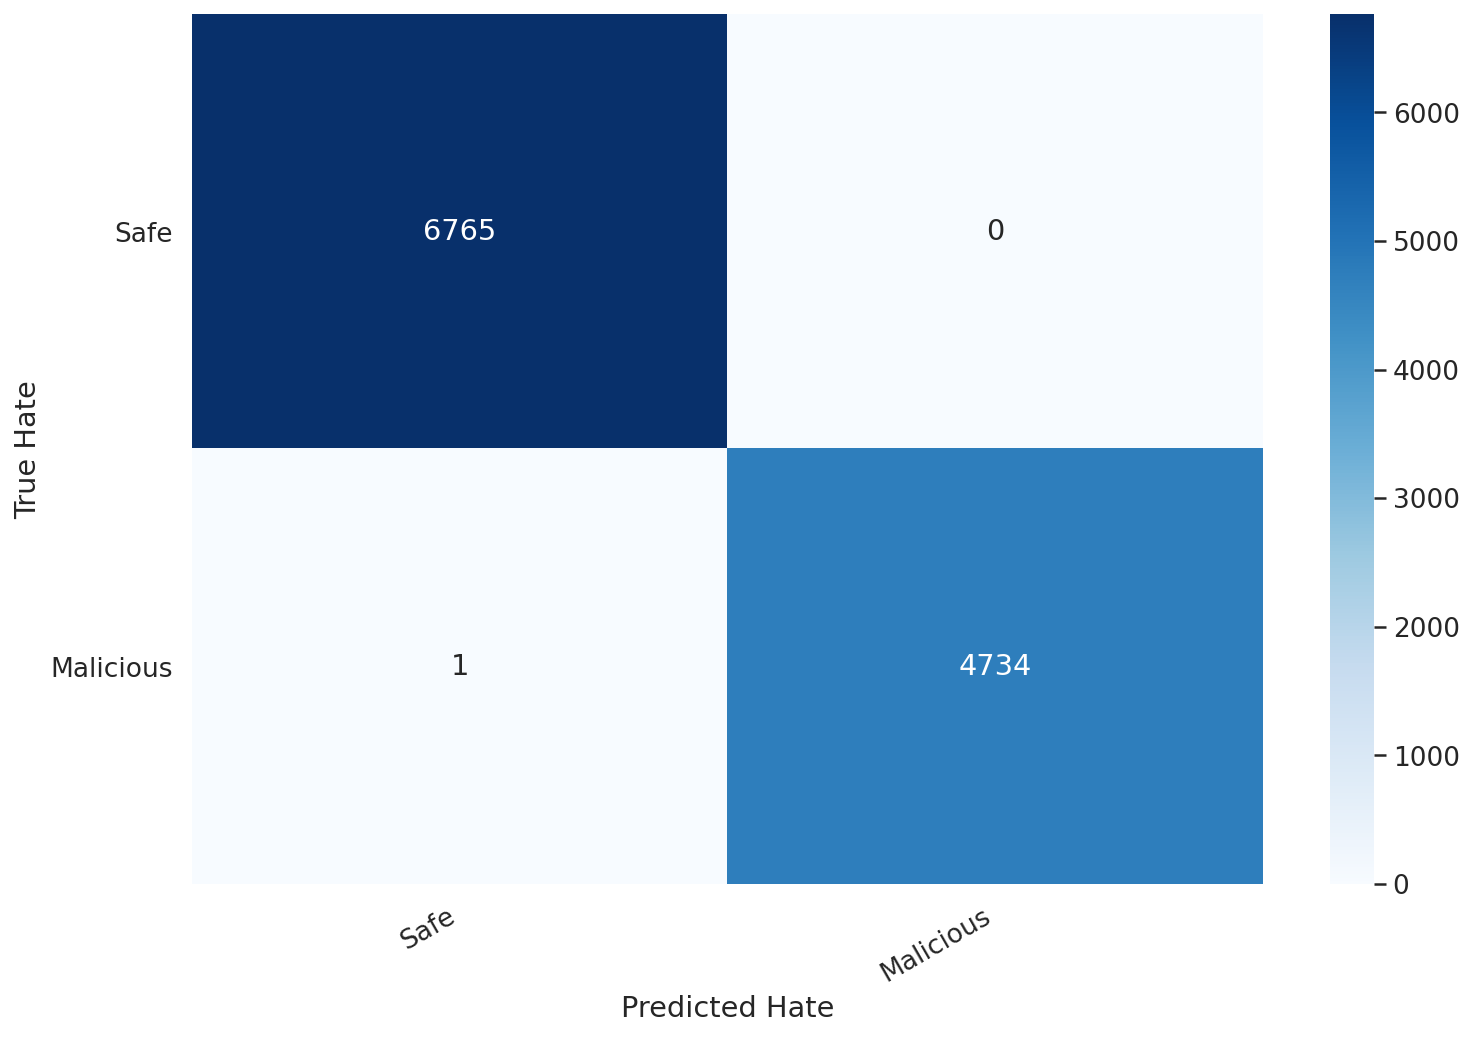

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Hate')
  plt.xlabel('Predicted Hate');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_url_text[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'Classified as : {class_names[true_sentiment]}')

http://www.qingzu.nl/traditionele-chinese-geneeskunde.html

Classified as : Malicious


## Prediction Tests

In [ ]:
review_text = 'https://dan.com/buy-domain/0nline.info?redirected=true&tld=info'

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review URL: {review_text}')
print(f'Class  : {class_names[prediction]}')

Review URL: https://dan.com/buy-domain/0nline.info?redirected=true&tld=info
Class  : Safe


In [ ]:
review_text2 = '	http://amazon.co.jp.odzvinb.cn/'

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text2,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review URL: {review_text}')
print(f'Class  : {class_names[prediction]}')

Review URL: https://dan.com/buy-domain/0nline.info?redirected=true&tld=info
Class  : Malicious
